In [554]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brendan45774/wine-quality")

print("Path to dataset files:", path)

Path to dataset files: /Users/patrickgunn/.cache/kagglehub/datasets/brendan45774/wine-quality/versions/2


In [555]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [556]:
import os

# Path to the downloaded dataset
path = r"/Users/patrickgunn/.cache/kagglehub/datasets/brendan45774/wine-quality/versions/2"

# List all files in the directory
files = os.listdir(path)
print("Files in the directory:", files)

Files in the directory: ['winequality-red.csv', 'winequality-white.csv']


In [557]:
import pandas as pd

# Path to the CSV file (replace with the actual file name)
csv_file_path = os.path.join(path, "winequality-white.csv")

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path, sep=";")

features = df.drop(columns=["quality"])

# Separate targets (only the "quality" column)
targets = df["quality"]
X_tensor = torch.tensor(features.values, dtype=torch.float32)

# Convert targets to a PyTorch tensor
y_tensor = torch.tensor(targets.values, dtype=torch.float32)

In [558]:
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
y_tr = y_tr.unsqueeze(-1)
y_te = y_te.unsqueeze(-1)

In [559]:
x_tr_mean, x_tr_std = x_tr.mean(0), x_tr.std(0)

x_tr = (x_tr - x_tr_mean) / x_tr_std
x_te = (x_te - x_tr_mean) / x_tr_std

y_tr_min, y_tr_max = y_tr.min(), y_tr.max()

y_tr = (y_tr - y_tr_min) / (y_tr_max - y_tr_min)
y_te = (y_te - y_tr_min) / (y_tr_max - y_tr_min)

In [560]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=5e-2, prior_var = 1):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # print('dim weights', weights.shape)

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # print('dim biases', biases.shape)
        # print('dim x', x.shape)
        # print('dim x @ weights', (x @ weights).shape)
        # print('dim x @ weights + biases', (x @ weights + biases).shape)
        return x @ weights + biases # (num_samples, batch_size, output_dim).






class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0

        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

In [561]:
bnn_model = MeanFieldBNN(11, [10, 10], 1, noise_std=0.6, prior_var = 0.12)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-3
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
  )
)


In [562]:
preds = bnn_model(x_te)

print(preds.mean(), preds.std())

tensor(0.8254, grad_fn=<MeanBackward0>) tensor(0.5256, grad_fn=<StdBackward0>)


100%|██████████| 4000/4000 [01:59<00:00, 33.36it/s]


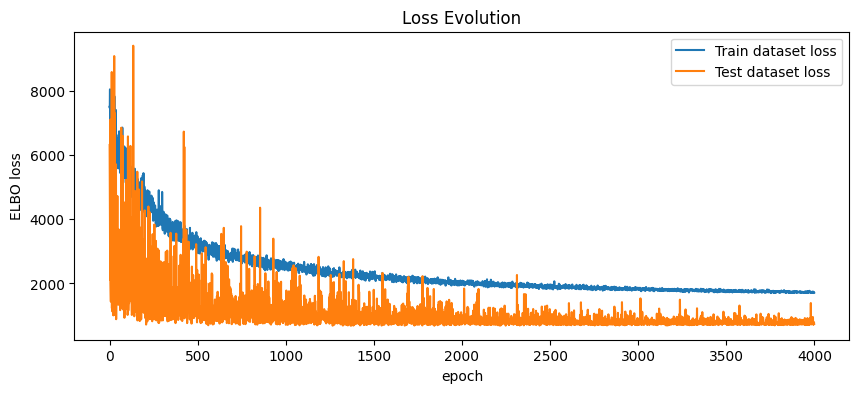

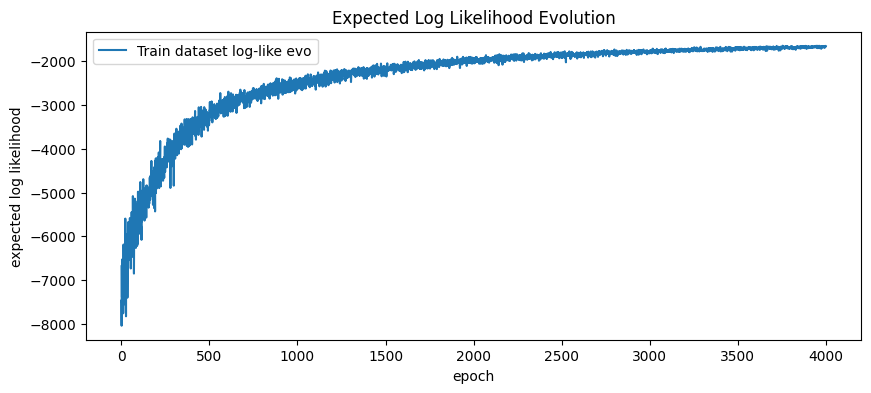

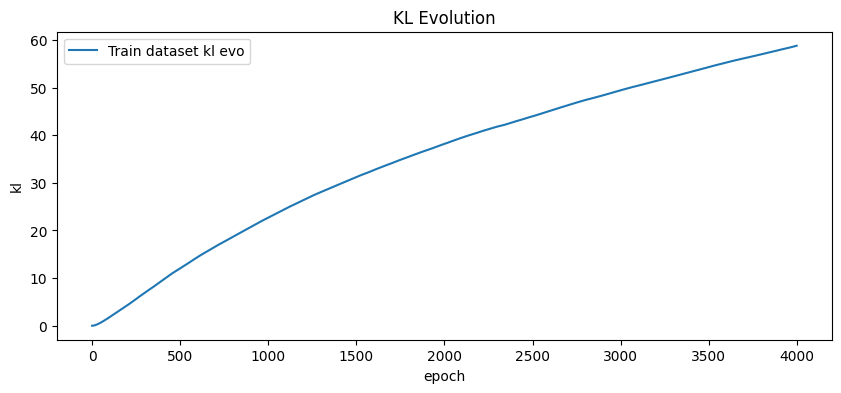

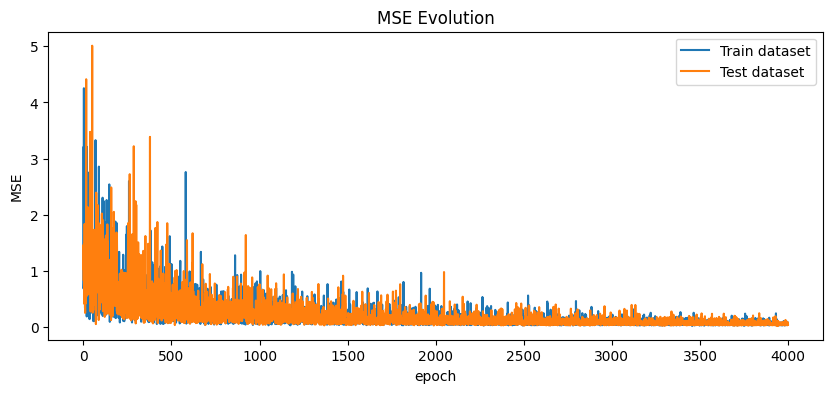

In [563]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(4000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr, num_samples = 100)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

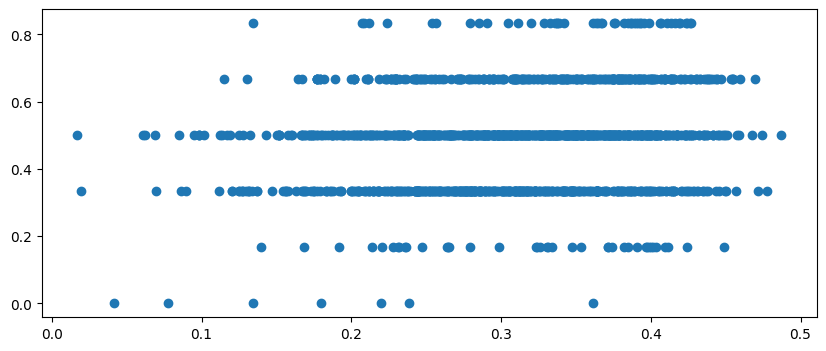

In [572]:
preds = bnn_model(x_te).squeeze(0).detach().numpy()
obs = y_te.detach().numpy()

plt.scatter(preds, obs)